<a href="https://colab.research.google.com/github/Coyote-Schmoyote/mask-detection/blob/main/Mask_detection_end_to_end_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object detection
Object detection is a computer vision task that is used to identify objects and their location inside an image. Object detection is often confused with image recognition, however, these two tasks are two distinct tasks. Image recognition assigns a label to an image. For example, a picture of a cat receives athe label "cat." Object detection, on the other hand, draws a bounding box around the cat, and labels the box "cat." In other words, object detection algorithm provides more information about hte target image than an image recognirion alogirthm.

Object detection has a number of real-world applications, including crowd counting, self-driving cars, video surveillance, face detection, anomaly detection, etc. 

## Object detection with dlib
Dlib has a pre-trained object detector, which already includes some object categories. For this project, we will train a custom object detector by manually creating annotations for our images using `imglab` and dlib function `train_simple_object_detector()`.

## Problem definition
Build an object detector, which will be able to detect faces with masks, and faces without the masks.

## Data
For this project, we are using a part of the COVID-19 Medical Face Mask Detection Dataset (https://www.kaggle.com/datasets/mloey1/medical-face-mask-detection-dataset). The dataset consists of 1415 images of people wearing face masks.
In principle, the more images we use to train our model, the more accurate the results will be. However, with the more images we use, the longer it takes to complete the training. Because of this, it is customary to first test the feasibility of the project by using a fraction of the data. 

In this project, we will use 35 images to train the model, 7 annotated images to test the model performance, and 7 images without annotations. In total, we will use 49 images to complete the mask detection project.

## Approach
To build our mask detector, our worflow will include 5 broad steps:
1. Tool and data preparation
2. Image labeling 
3. Custom object detector training
4. Combining object and face detectors


## 1. Preparation
First, we need to install and import the tools that we will be working with.
Similar to our previous computer vision project that covered face detection and recognition (https://colab.research.google.com/drive/1cePrw5eqlCWvsJix2xZLgA7m8eUqCxU2), we will need to install `dlib` and `open cv`.

In [1]:
#install image detection tools
!pip install dlib==19.18.0 
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 36.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.9 MB 143 kB/s 


In [2]:
#import tools
import matplotlib.pyplot as plt
import os
import random
import cv2
from google.colab.patches import cv2_imshow
import dlib

After we have installed our libraries, it is a good idea to check their versions. In the future, if one library gets updated, some of its functions may become incompatible with other libraries. Therefore, knowing the version might potentially save us a lot of time if our algorithm suddenly stops working.

In [3]:
#check library versions
print(f"Dlib version: {dlib.__version__}")
print(f"Open CV version: {cv2.__version__}")

Dlib version: 19.18.0
Open CV version: 4.6.0


### OS module
OS module is a very common tool in Python that provides functions to facilitate the interaction with out operating system. For example, if we need to access a certain file or a folder on our computer (or in this case, in our Google Drive), `os` module enables us to do it fairly easily. 

More specifically, we will use the `os.path` module to manipulate paths. It allows us not only provide an easy access to our data, but also makes it easier if we want to make changes in the original directory. 

One of themost useful functionalities of `os.path` is `os.path.join`. This method concatenates path components by accepting them as arguments.

In [27]:
# save path to the project folder
project_folder = "/content/drive/MyDrive/ml-projects/dlib-computer-vision-project/"
train_img_folder = os.path.join(project_folder, "train/")
test_img_folder = os.path.join(project_folder, "test/")

### Selecting random image from a folder
If we want to display a new image every time we refresh our cell, we can use a combination of `os` and `random` modules. `Random` is a built-in python module that implements pseudo-random number generators. The `random.choice()` method returns a random element from a list. In our case, we want it to retunt a random image (element) from our train folder (list). In order to convert all our files in the train folder into a list, we wil use the `os.listdir()` method.

Then, we will save the path to the image as a varibale by combining the paths of the training folder and the random image. This way, everytime we refresh our cell, we will get a different image from the folder.


Finally, to display the image, we need to load it using `dlib.load_rgb_image()`, and then display with `pyplot`.

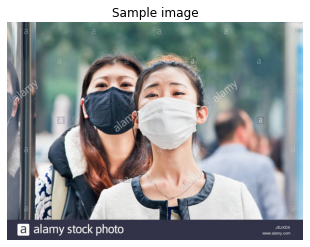

In [5]:
#save path for a random image
random_image_path = random.choice(os.listdir(train_img_folder))
random_image = os.path.join(train_img_folder, random_image_path)

#load random image to dlib
random_image_load = dlib.load_rgb_image(random_image)

#display the random image
plt.imshow(random_image_load)
plt.title("Sample image")
plt.axis("off");

## 2. Annotation of the images

When training a custom object detector, we need to show the model which object to detect by labelling the images from the training dataset and drawing bounding boxes with coordinates around the desired object. This process is called image annotaiton. To train a custom object detector, we need to manually annotate each image. The annotation tool saves the coordinates for each bounding box in an `.xml` file, which we will then pass to our model.

There are many free and paid image labelling tools, such as V7, LabelImg, ScaleAi, etc. For our current project, we will use Img Lab.

### Img Lab
Img Lab is a free open-source and web-based image annotation tool. It provides a range of label types, including points, circules, bounding boxes, and polygons, and most importantly, it exports the annotation file in a format that is tailored specifically to`dlib`.

<img src="https://drive.google.com/uc?id=1uqWFBcppQrWfIA4CQyCH_H19Rdotf8L4" width="600"> 

One way to use `imglab` is by installing it with pip through the command line and run it on the local server. Another way is by using the web version of img lab at https://imglab.in. The web version provides a Graphic User Interface (GUI) which makes it intuitively easy to navigate. 
After accessing the website, we will go through the following steps:
1. Upload the folder with the training images.
2. Select each image, draw a bounding box around the mask, and create new category name and label name on the left side of the window.
3. Complete annotating all images in the folder.
4. Export the annotaions as DLIB `.xml` file, and save it in the same folder with the rest of the training images.
5. Repeat the process for the testing images.

> Note: As we mentioned in the face detection tutorial, `dlib` doesn‘t recognize face (or objects) that are less that 80 pixels. When labeling our images, we need to be mindful of this, and draw the bounding boxes with the correct size in mind. The incorrect size of the bounding boxes might also cause the Google Colab session to crash.


After we have completed the annotations, let‘s save the path to the `.xml` files using `os.path.join`.


In [6]:
# save path to the annotaitons
training_xml_path = os.path.join(train_img_folder, "train.xml")
testing_xml_path = os.path.join(test_img_folder, "test.xml")

## 3. Train simple object detector

Now that we have prepared our data, we are ready to train our custom object detector. 
Luckily, `dlib` has the `train_simple_object_detector()` function, which makes the process very easy. The function accepts the following arguments: the path to the xml with annotations, the name of the detector file with `.svm` extension, and the list of hyperparameters. 

First, let‘s take a look at the available hyperparameters by printing out the `dlib.simple_object_detector_trianing_options()` .

In [7]:
#check out the parameters of the simple object detector
options = dlib.simple_object_detector_training_options()
print(options)

simple_object_detector_training_options(be_verbose=0, add_left_right_image_flips=0, num_threads=4, detection_window_size=6400, C=1, epsilon=0.01, max_runtime_seconds=3.1536e+09, upsample_limit=2, nuclear_norm_regularization_strength=0)


### Simple object detector options
As we can see, there are many hyperparameter tuning options. Some of the most relevant ones are as follows:
* `add_left_right_image_flips`
 > This option tells the model to train a symmetric detector by flipping the images horizontally.
* `C`
 > Simple object detector is a type of a support vector machine, and therefore uses the usual C parameter. In general, the bigger the C, the higher is the fit of the training data. However, C that is too big might result in overfitting. The best C value is found through experimentaiton. 
* `num_threads`
> This option tells how many CPU cores your computer has for the fastest training.

In [8]:
# specify the params
options.add_left_right_image_flips = True
options.C = 9
options.num_threads = 2
options.be_verbose = True

### Training the model
Now we are ready to actually train the model. The input of the model is the `.xml` file that lists all the images in the training dataset, and contains the coordinates of the bounding boxes of each image. The output is the `.svm` file with the trained detector.

To see how long it takes to train a model on 35 images, we can use a magic comand `%%time`. It will measure how long it took a cell to run. 
After we trained the model, we can save it as a variable.

In [9]:
# train the detector and check the time required for training
%%time
dlib.train_simple_object_detector(training_xml_path, "mask_detector.svm", options)

CPU times: user 6min 54s, sys: 2.06 s, total: 6min 56s
Wall time: 4min 15s


In [10]:
#save the mask detector
mask_detector = dlib.simple_object_detector("mask_detector.svm")

## Test the model
After we trained the model, we have to test it to know how well does it perform. `dlib` library provides a `dlib.test_simple_object_detector()` function, that tells us the precision, recall, and average precision of model.
To see how our model performs, let‘s print out both the training accuracy, based on our `training.xml`, and testing accuracy, based on `testing.xml`.

#### Precision
Precision refers to the ration of the number of true positives to the total number of positive predictions. For instance, if the model detected 100 masks, and 90 were correct, the precision is 90%. However, it is not a very accurate metric, because it doesn‘t account for the instances that were predicted incorrectly. Therefore, when we talk about the accuracy metrics, we often have to look at both precision and recall. 

#### Recall
Recall measures how well the model can find all the positives. In other words, if the model correctly detects 75 masks in an image, but there are actually 100 masks, the recall is 75%.

#### Average precision
Average precision (AP) is a popular accuracy metric when measuring the performance of object detectors. AP calculates  finds the area under the precision-recall curve. The precision-recall curve is a plot of precision (y-axis) and recall (x-axis). The model is considered a good if the precision stays high as the recall increases.

In [11]:
# check training accuracy
print(f"Training accuracy: {dlib.test_simple_object_detector(training_xml_path, mask_detector)}")

Training accuracy: precision: 1, recall: 0.895522, average precision: 0.895522


In [12]:
print(f"Testing accuracy: {dlib.test_simple_object_detector(testing_xml_path, mask_detector)}")

Testing accuracy: precision: 0.764706, recall: 0.866667, average precision: 0.806944


## Testing with the actual images
Ok, the evaluation metrics look pretty good, despite the fact that we trained the model on a handful of examples. 
Let‘s see visually how well our models works by testing it by providing actual images as an input.

We will write 2 functions: The first one will take a folder path as an input, and will be responsible for selecting a random image from a folder, loading it into `dlib` format and then converting it from RGB to BGR. The function will return the image as an output.

In [13]:
#write a function that chooses a random image from a folder, uploads it to dlib, and converts RGB to BGR
def load_img(folder_path):
  """
  Chooses random image from a folder, uploads it to dlib, converts RGB to BGR, and returns the image
  """
  #select random image 
  random_image_path = random.choice(os.listdir(folder_path))
  random_image = os.path.join(folder_path, random_image_path)
  #upload the image to dlib
  rgb_image = dlib.load_rgb_image(random_image)
  #convert RGB to BGR
  image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
  return image

The second function will be responsible for drawing the bounding boxes using `open cv` around the detected mask. To upload the image, we will use our first function, and then we will find the coordinates by using our trained mask detector. 

In [14]:
# write a function that detects the mask and creates a bounding box around it
def detect_mask(folder):
  """
  a function that detects mask using dlib object detector, and generates a bounding box around the object
  """
  #load the image
  image = load_img(folder)
  #find coordinates
  boxes = mask_detector(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  #generate a bounding box
  for b in boxes:
    (x, y, w, h) = (b.left(), b.top(), b.right(), b.bottom())
    detected_image = cv2.rectangle(image, (x, y), (w, h), (0, 255, 0), 2)
    # input text above the top left corner of the bounding box
    font = cv2.FONT_HERSHEY_PLAIN
    detected_image = cv2.putText(image, "Mask Detected", (x, y-10), font, 1.0, (0, 255, 0))

  #display the image
  cv2_imshow(image)

Great! Now let‘s test our detector on the images from the training folder first.

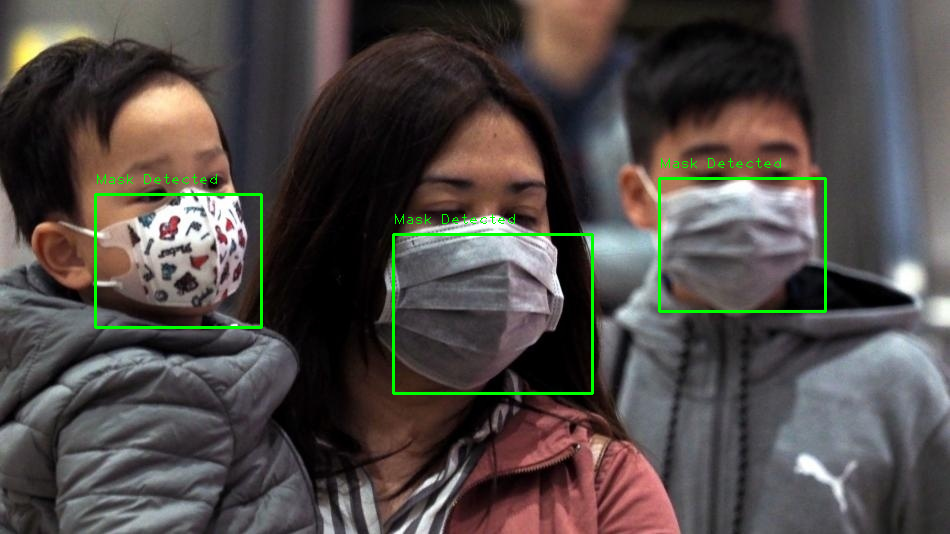

CPU times: user 268 ms, sys: 4 ms, total: 272 ms
Wall time: 287 ms


In [15]:
#detect mask on training set
%%time
detect_mask(train_img_folder)

Not bad... Now, let‘s use the same function to see how well our model can predict masks on the images it has never seen before, using the data from the test folder.

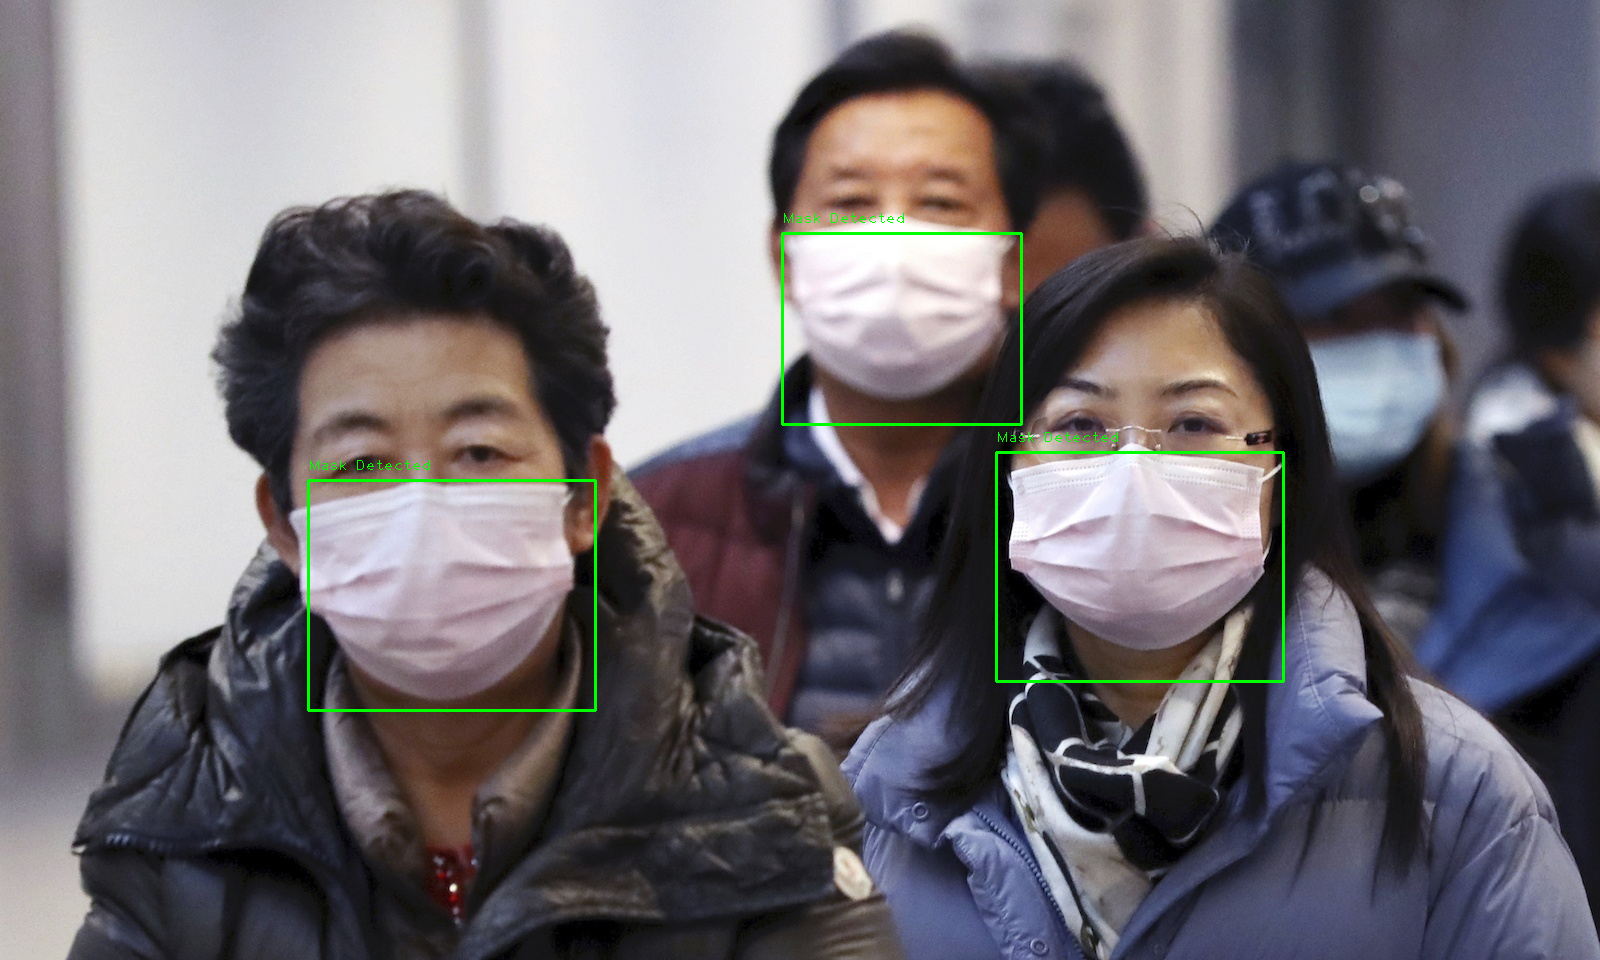

In [16]:
#detect mask on test data
detect_mask(test_img_folder)

## 4. Combine mask detector with MMOD face detector
Our model did pretty good! However, wouldn‘t it be nice if our detector also could detect people who don‘t wear masks? While we could try training a separate object detector for faces without masks, as we already saw, it‘s a rather time consuming process, particularly in terms of image labelling. Let‘s try comibining our custom mask detector with an existing MMOD detector, the same one we used in the previous project. 

In [17]:
# load a mmod face detector
face_detector = dlib.cnn_face_detection_model_v1("/content/drive/MyDrive/ml-projects/dlib-computer-vision-project/mmod_human_face_detector.dat")

Now let‘s write a function that will create a bounding box around the face detected by our MMOD face detector, and combine it with a bounding box around the mask, detected by our custom object detector.

In [25]:
def detect_mask(image):

  face = face_detector(image, 0)

  for faceRect in face:
    rect = faceRect.rect
    x1 = rect.left()
    y1 = rect.top()
    x2 = rect.right()
    y2 = rect.bottom()

    cv2.rectangle(image, (x1, y1), (x2, y2), (255 , 0, 255), 2)

  boxes = mask_detector(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  for b in boxes:
    (x, y, w, h) = (b.left(), b.top(), b.right(), b.bottom())
    detected_image = cv2.rectangle(image, (x, y), (w, h), (0, 255, 0), 2)
    font = cv2.FONT_HERSHEY_PLAIN
    detected_image = cv2.putText(image, "Mask detected", (x, y-10), font, 1.0, (0, 255, 0), 2)
    
  cv2_imshow(image)

## Test the final detector

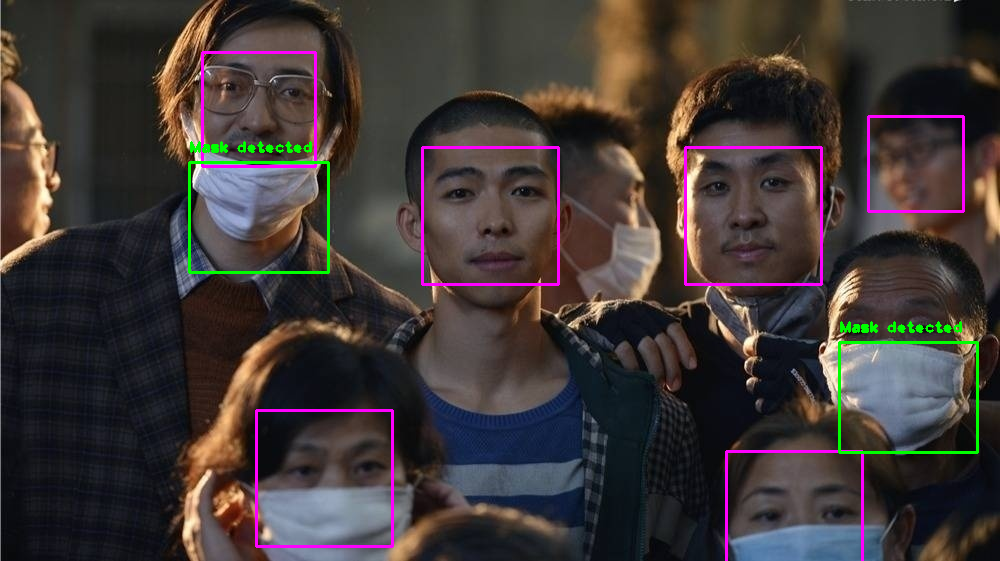

In [26]:
sample_image = load_img("/content/drive/MyDrive/ml-projects/dlib-computer-vision-project/sample-images/")
detect_mask(sample_image)